In [4]:
import h5py
from pathlib import Path
import seaborn as sns
import whirligig
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy import optimize
home = Path.home()

penn_state_data = home/'iCloud'/'penn_state_synca_data'
cres2_vna = penn_state_data/'vna'/'211220_cres2_vna_trace.h5'

cres2_vna_no_correction = penn_state_data/'vna'/'211119_cres2_vna_trace.h5'

#jugaad_data = home/'iCloud'/'jugaad_data'/'rotated'/'data.h5'
jugaad_data = home/'iCloud'/'jugaad_data'/'Characterization'/'data.h5'

def synca_phase_model1(radial_position, roll=0, n=60):
    #radial position in mm
    wavelength = 3e8 / 25.86e9
    r_array = 0.1
    theta_array = np.arange(0, n, 1) * 2 * np.pi / n
    x_array = r_array * np.cos(theta_array)
    y_array = r_array * np.sin(theta_array)

    d = np.sqrt((x_array - radial_position*0.001) ** 2 + y_array ** 2)
    arctan = np.arctan2(y_array, radial_position*0.001-x_array)
    #arctan = np.arange(0, 120, 1)*2*np.pi/120
    #print(arctan)
    spatial = 2*np.pi * d/wavelength
    phase = np.unwrap(np.roll(spatial+arctan, roll))
    phase -= phase[0]
    
    return phase

def synca_phase_model2(radial_position, roll=0, n=60, invert=False):
    #radial position in mm
    wavelength = 3e8 / 25.86e9
    r_array = 0.1
    theta_array = np.arange(0, n, 1) * 2 * np.pi / n
    x_array = r_array * np.cos(-theta_array)
    y_array = r_array * np.sin(-theta_array)

    d = np.sqrt((x_array - radial_position*0.001) ** 2 + y_array ** 2)
    arctan = np.arctan2(-y_array, radial_position*0.001-x_array)
    #arctan = np.arange(0, 120, 1)*2*np.pi/120
    #print(arctan)
    spatial = 2*np.pi * d/wavelength
    if invert:
        phase = np.roll(spatial, -roll) - arctan
    else:
        phase = np.roll(spatial, roll) + arctan
    phase -= phase[0]
    
    return phase

def synca_phase_model3(radial_position, roll=0, n=60, invert=False):
    #radial position in mm
    wavelength = 3e8 / 25.86e9
    r_array = 0.1
    theta_array = np.arange(0, n, 1) * 2 * np.pi / n
    x_array = r_array * np.cos(theta_array)
    y_array = r_array * np.sin(theta_array)

    d = np.sqrt((x_array - radial_position*0.001) ** 2 + y_array ** 2)
    arctan = np.arctan2(y_array, radial_position*0.001-x_array)
    #arctan = np.arange(0, 120, 1)*2*np.pi/120
    #print(arctan)
    spatial = 2*np.pi * d/wavelength
    if invert:
        phase = np.roll(spatial, -roll) - arctan
    else:
        phase = np.roll(spatial, roll) + arctan
    phase -= phase[0]
    
    return phase

def phase_shift_processor(curve, model):
    
    difference = model - curve
    phase_shifts = 2*np.pi * np.round(difference/(2*np.pi), 0)
    
    return curve+phase_shifts
    

def read_raw_penn_vna_data(path):
    
    dir1_list = list(path.glob('*'))
    raw_data = {}
    h5file = h5py.File(path.parent/(path.name+'.h5'), 'w')
    
    
    for i, dir1 in enumerate(dir1_list):
        if dir1.name != '.DS_Store':
            raw_data[dir1.name.split('_z')[-1].split('mm')[0]] = {}
            dir2_list = list(dir1.glob('*'))
            for j, dir2 in enumerate(dir2_list):
                if dir2.name != '.DS_Store':
                    raw_data[dir1.name.split('_z')[-1].split('mm')[0]][dir2.name] = {}
                    filez_list = list(dir2.glob('*'))
                    for k, file in enumerate(filez_list):
                        if file.name != '.DS_Store':
                            angle = file.name.split('.')[0]
                            with open(file, 'r') as infile:
                                file_reader = csv.reader(infile)
                                for l, line in enumerate(file_reader):
                                    if l == 0:
                                        line = np.array(line, dtype=np.float64)
                                        line = line[np.arange(0, line.size, 2)] + 1j * line[np.arange(1, line.size, 2)]
                                        raw_data[dir1.name.split('_z')[-1].split('mm')[0]][dir2.name][angle]=line

    angles = np.sort(np.int32(np.array(list(raw_data['0']['0'].keys()))))
    radii = np.sort(np.int32(np.array(list(raw_data['0'].keys()))))
    n_frequencies = raw_data['0']['0']['0'].size
    
    for i, dir1 in enumerate(dir1_list):
        if dir1.name != '.DS_Store':
            key = dir1.name.split('_z')[-1].split('mm')[0]
            
            data_array = np.zeros((radii.size, angles.size, n_frequencies), dtype=np.complex64)
            
            for j, j_rad in enumerate(radii):
                for k, k_ang in enumerate(angles):
                    data_array[j, k, :] = raw_data[key][f'{j_rad}'][f'{k_ang}']
                    
            h5file.create_dataset(key, data = data_array)
            
    h5file.close()
                                
            
def fit_func(x,a,b,c,d,e,f,g,h,i,j,k):
    
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6 + h*x**7 + i*x**8 + j*x**9 + k*x**10
        


# calculate phase calibration

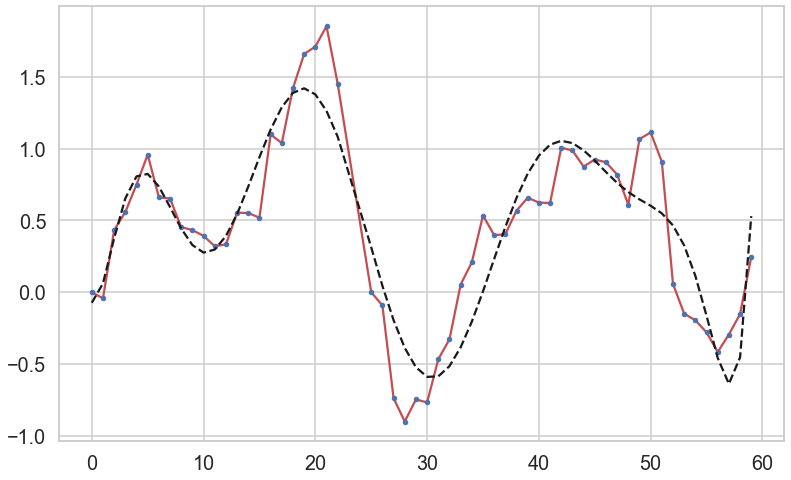

In [6]:
# fit a polynomial to the phase deviation data from r00z00

jugaad_data = home/'iCloud'/'jugaad_data'/'Characterization'/'data.h5'
jugaadfile = h5py.File(jugaad_data, 'r')

#phase_mask
mask = np.ones(60, dtype=bool)
mask[23:25]=0

color_dict = {0:'b', 1:'r', 2:'g'}

sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

mean_mean_phase_curve = np.zeros(60)[mask]
#mean_mean_phase_curve_rot = np.zeros(60)[mask_rot]

for k, r in enumerate([0]):
    if r < 10:
        i_data = jugaadfile[f'r0{r}z00']
    else:
        i_data = jugaadfile[f'r{r}z00']
        
    model_curve = -synca_phase_model1(r, roll=-14)[mask]
    mean_curve = np.zeros(60)[mask]
    for i in range(i_data.shape[1]):
        initial_phase = np.angle(i_data[0, i, 1, 0])
        i_curve = (np.unwrap(np.angle(i_data[:, i, 1, 0]))-initial_phase)[mask]
        shifted_i_curve = phase_shift_processor(i_curve, model_curve)
        mean_curve += (model_curve - shifted_i_curve) / i_data.shape[0]

    ax.plot(np.arange(0,60,1)[mask], mean_curve, color='r')
    popt,pcov = optimize.curve_fit(fit_func, np.arange(0, 60, 1)[mask], mean_curve)    
    fit_curve = fit_func(np.arange(0,60,1)[mask], *popt)

    
ax.plot(np.arange(0, 60, 1)[mask], mean_curve,'.')
ax.plot(np.arange(0, 60, 1)[mask], fit_curve, color='k', ls='--')


np.save(Path.home()/'iCloud'/'jugaad_data'/'calibrations'/'phase_cal.npy', popt)
#ax.plot(np.arange(0, 60, 1)[mask_rot], np.roll(mean_mean_phase_curve_rot, -9) - np.roll(mean_mean_phase_curve_rot, -9)[0])

# calculate mag calibration

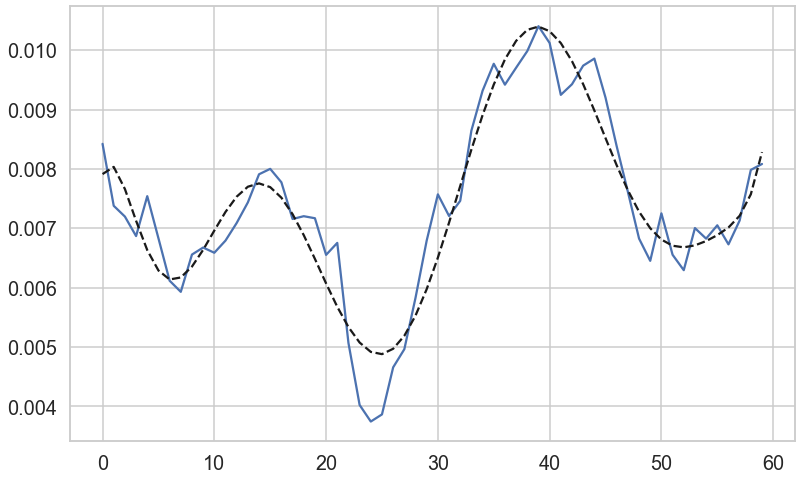

In [348]:
# fit a polynomial to the r00z00 data

jugaad_data = home/'iCloud'/'jugaad_data'/'Characterization'/'data.h5'
jugaadfile = h5py.File(jugaad_data, 'r')

color_dict = {0:'b', 1:'r', 2:'g'}

sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)


for k, r in enumerate([0]):
    if r < 10:
        i_data = jugaadfile[f'r0{r}z00']
    else:
        i_data = jugaadfile[f'r{r}z00']
    
    mean_curve = np.zeros(60)
    for i in range(i_data.shape[1]):
        i_curve = abs(i_data[:, i, 1, 0])
        mean_curve += (i_curve) / i_data.shape[1]

    popt,pcov = optimize.curve_fit(fit_func, np.arange(0, 60, 1), mean_curve)
    
    fit_curve = fit_func(np.arange(0,60,1), *popt)
        
    ax.plot(np.arange(0, 60, 1), mean_curve)
    ax.plot(np.arange(0, 60, 1), fit_curve, 'k--')
    #ax.plot(np.arange(0, 60, 1), np.roll(fit_func(np.arange(0, 60, 1), *popt_rot), -9), color='r')
    
    #ax.plot(np.arange(0, 60, 1), np.roll(20*np.log10(mean_curve_rot), -9), lw=3)
    

np.save(Path.home()/'iCloud'/'jugaad_data'/'calibrations'/'mag_cal.npy', popt)

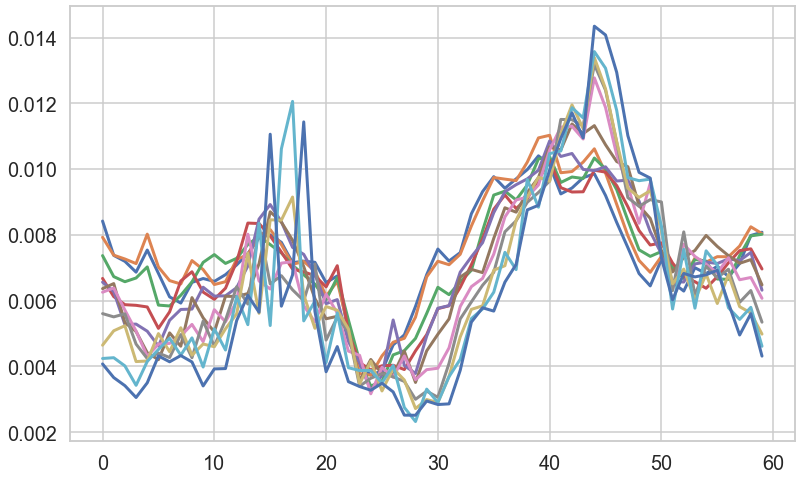

In [158]:

jugaad_data = home/'iCloud'/'jugaad_data'/'Characterization'/'data.h5'
jugaadfile = h5py.File(jugaad_data, 'r')

color_dict = {0:'b', 1:'r', 2:'g'}

sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)


for k, r in enumerate([0,5,10,15,20,25,30,35,40,45,50]):
    if r < 10:
        i_data = jugaadfile[f'r0{r}z00']
    else:
        i_data = jugaadfile[f'r{r}z00']
    
    #sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
    #fig = plt.figure(figsize=(13, 8))
    #ax = fig.add_subplot(1,1,1)
    
    mean_curve_jugaad = np.zeros(60)
    for i in range(i_data.shape[1]):
        i_curve = abs(i_data[:, i, 1, 0])
        

        #'''
        #ax.plot(
        #    np.arange(0, 60, 1)[mask],
        #    -1*synca_phase_model1(r, roll=-14)[mask],
        #)
        #ax.plot(
        #    np.arange(0, 60, 1),
        #    i_curve,
        #    '-'
        #)
        #'''
        #ax.plot(np.arange(0, 60, 1)[mask]*6, i_curve[mask] + phase_shift[mask],)
        mean_curve_jugaad += (i_curve) / i_data.shape[1]
        #plt.show()
        
    #ax.plot(np.arange(0, 60, 1)[mask], mean_curve_jugaad[mask])
    '''
    ax.plot(
        np.arange(0, 60, 1)[mask]*6,
        -synca_phase_model1(r, roll=-14)[mask] - (i_curve[mask]+phase_shift[mask]),
        label = f'{r} mm'
    )
    '''
    #ax.plot(np.arange(0, 60, 1), model_curve, color='k', lw=3 )
    ax.plot(np.arange(0, 60, 1)[mask], mean_curve_jugaad, lw=3)
    
    #ax.plot(np.arange(0, 60, 1)[mask], np.roll(mean_curve_jugaad - model_curve,0))
    
#ax.legend()
#plt.savefig(Path.home()/'iCloud'/'plots'/'221206_corrected_synca_model_rel_phase_error', dpi=128)

# radial sweep penn state

In [5]:
penn_h5file = h5py.File(cres2_vna, 'r')
penn_data = penn_h5file['range3cm_step1mm_z0mm']['array'][:]
penn_data = penn_data[:, 0:120, :]
penn_data = np.roll(penn_data,33, axis=1)
print(penn_data.shape)

(31, 120, 801)


<ipython-input-20-a3835b89acb5>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(13, 8))


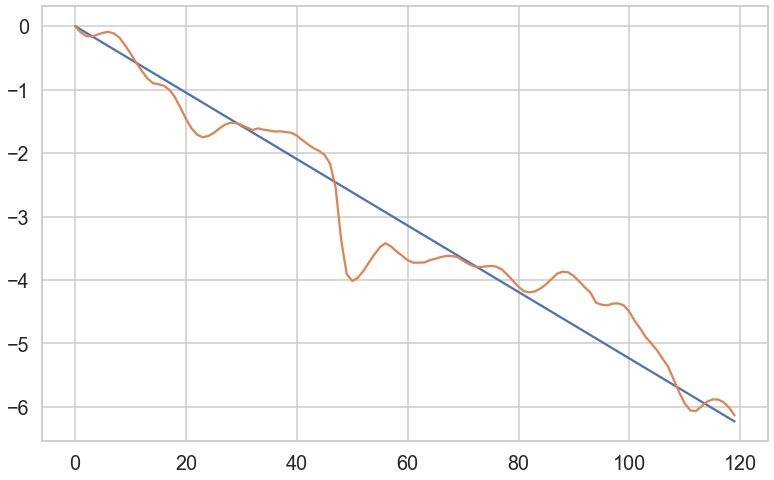

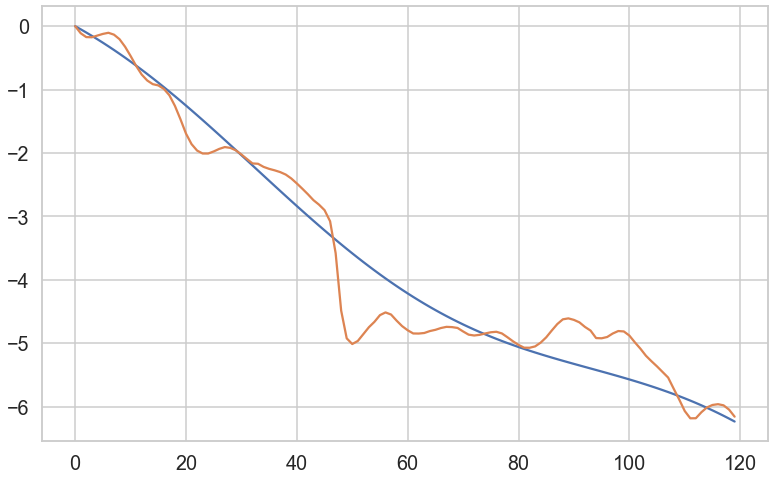

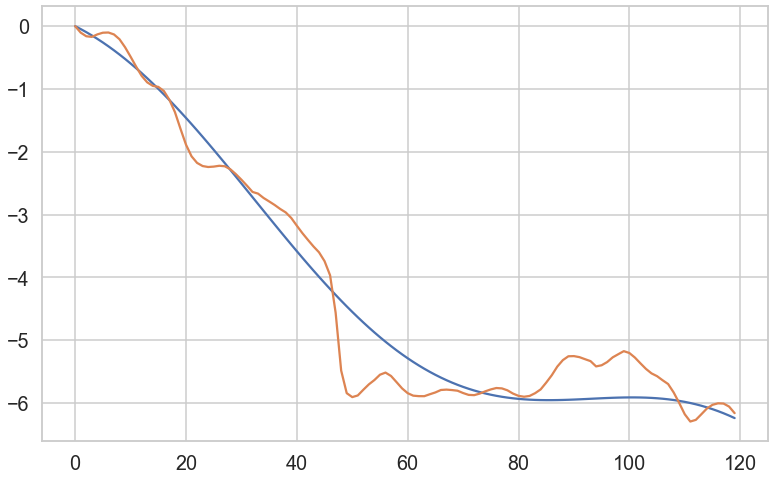

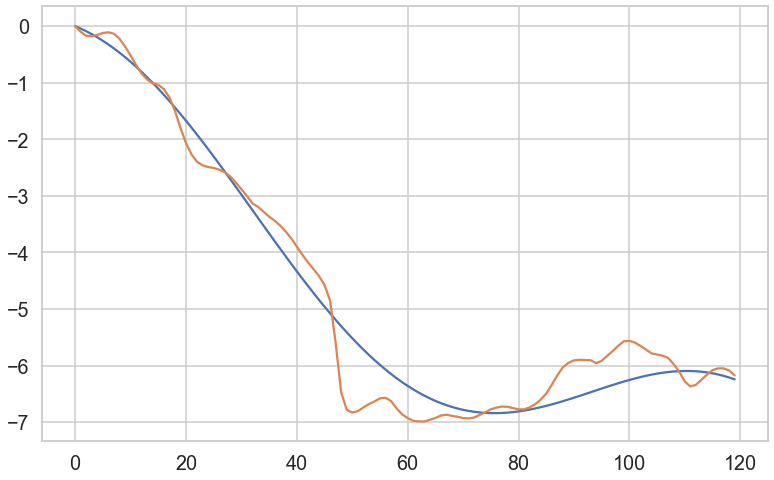

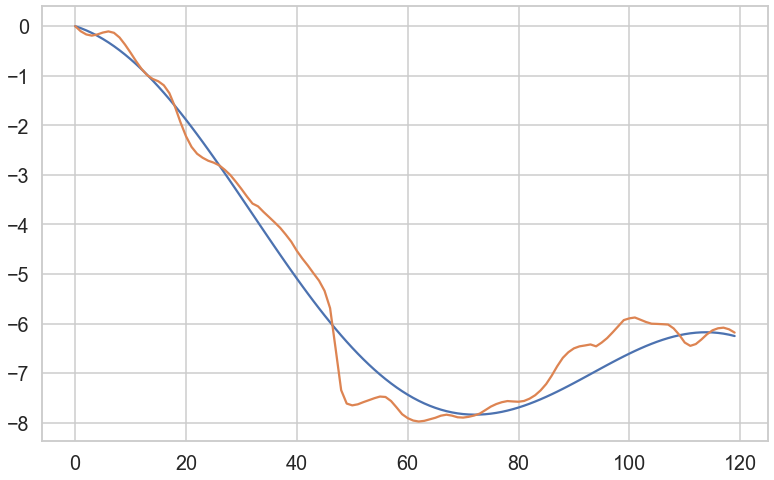

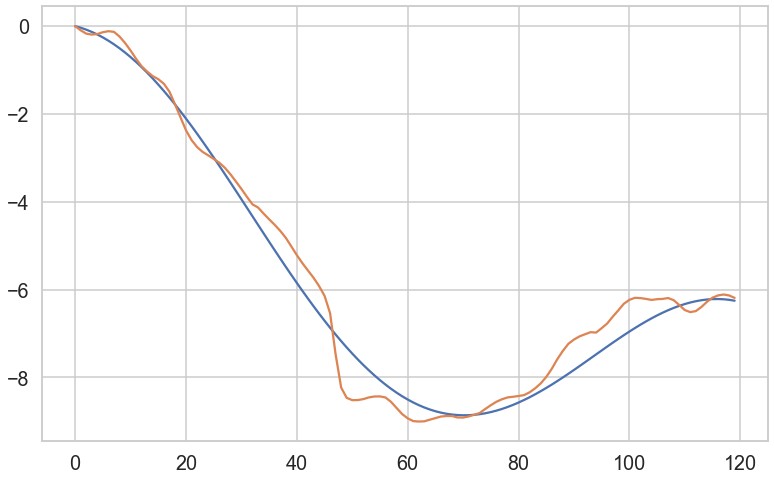

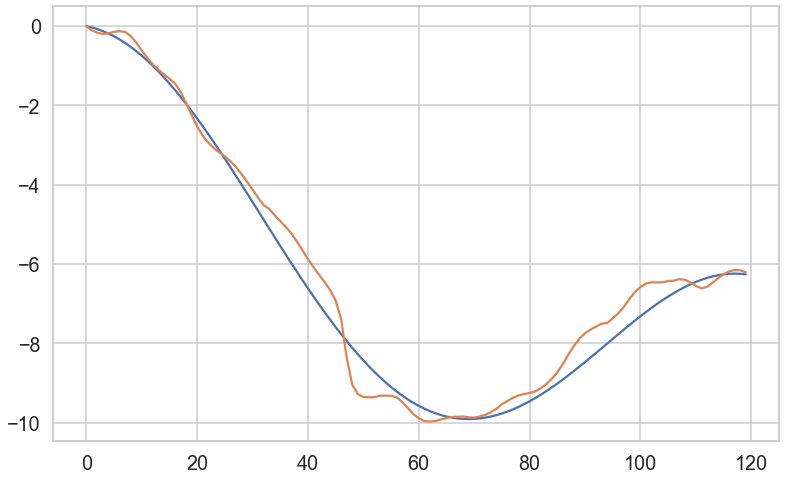

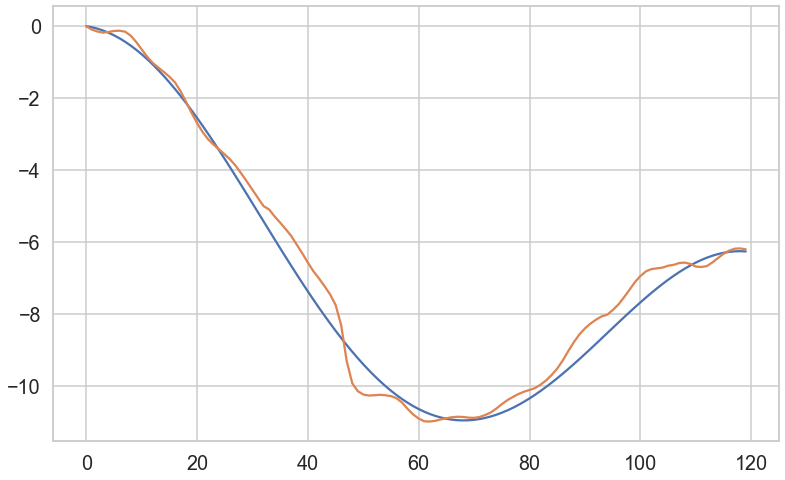

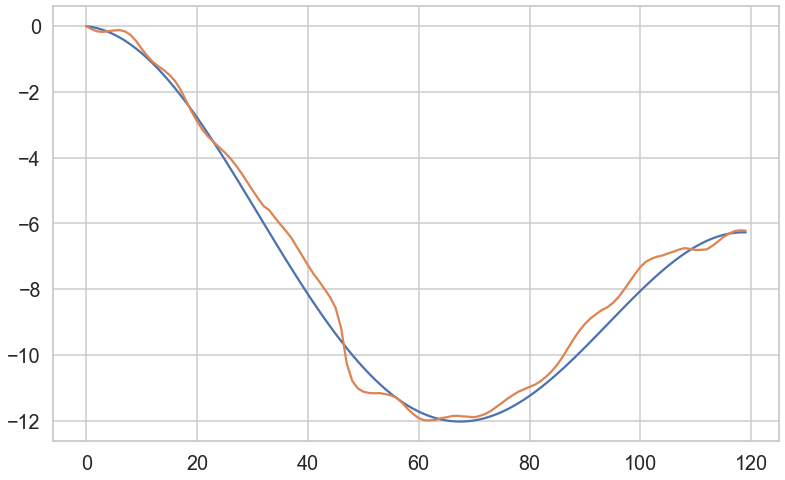

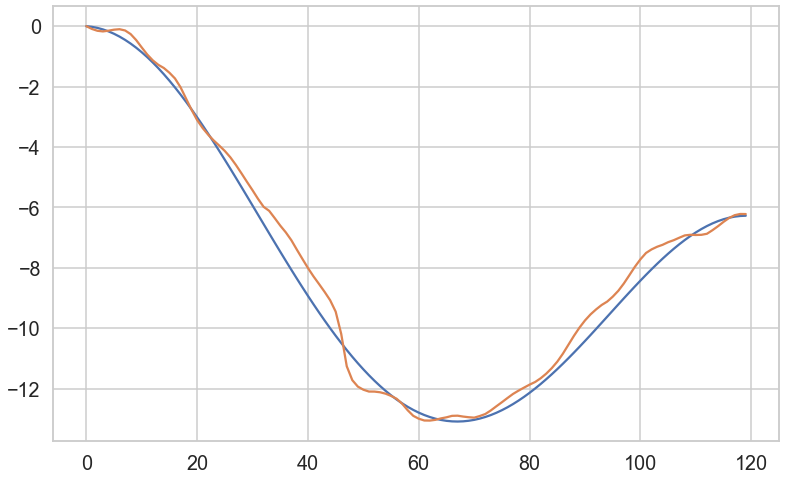

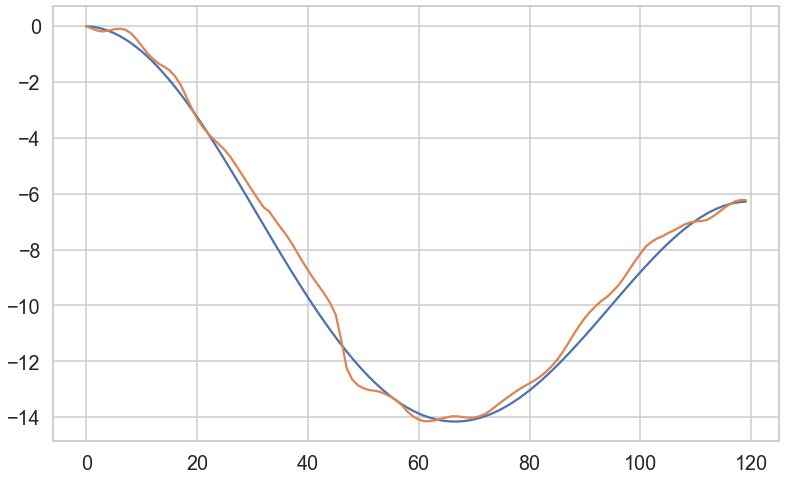

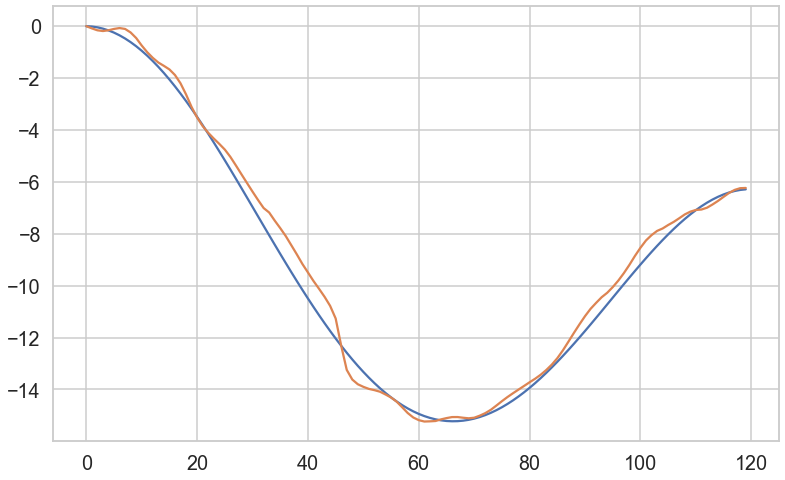

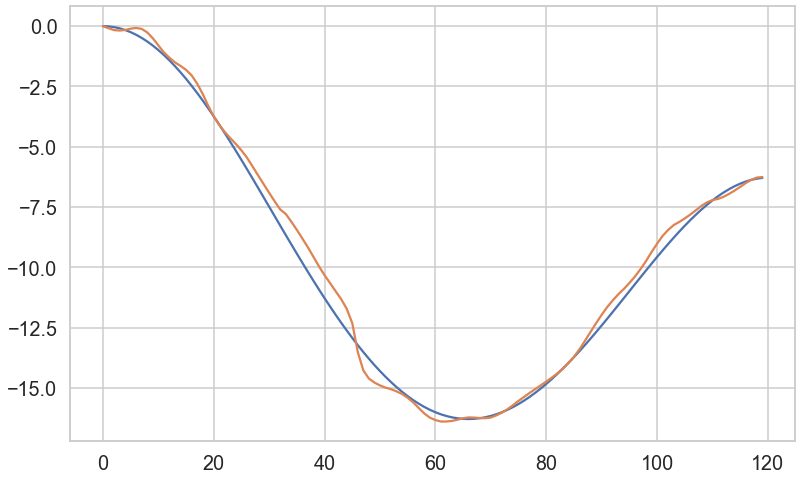

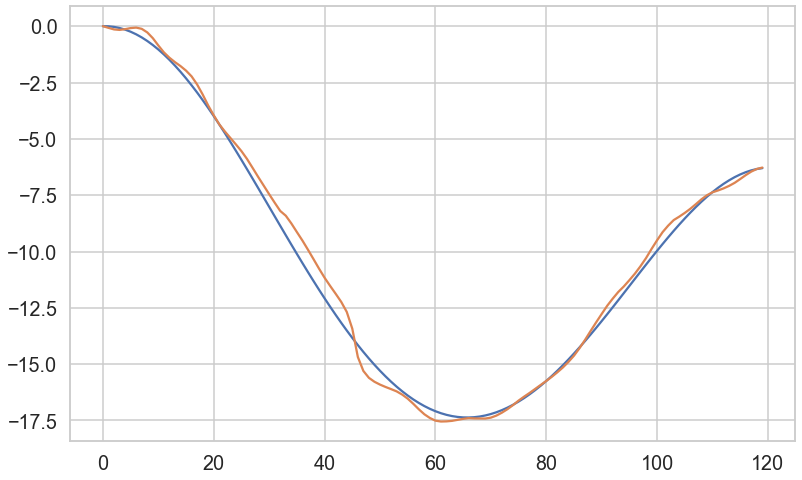

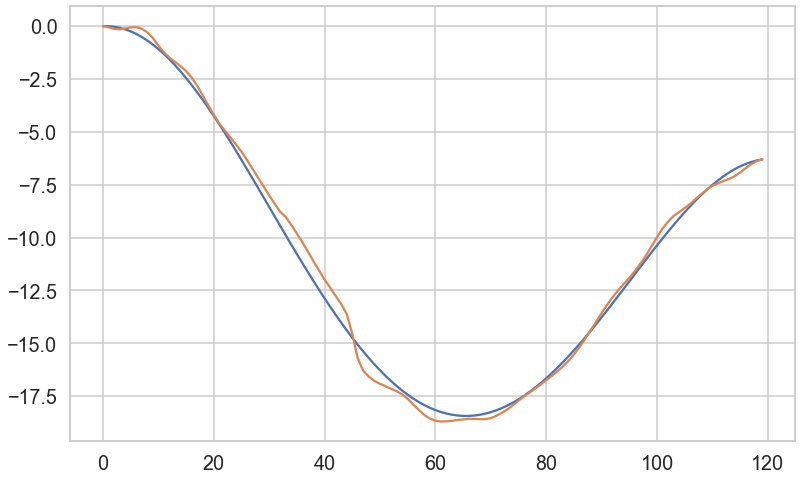

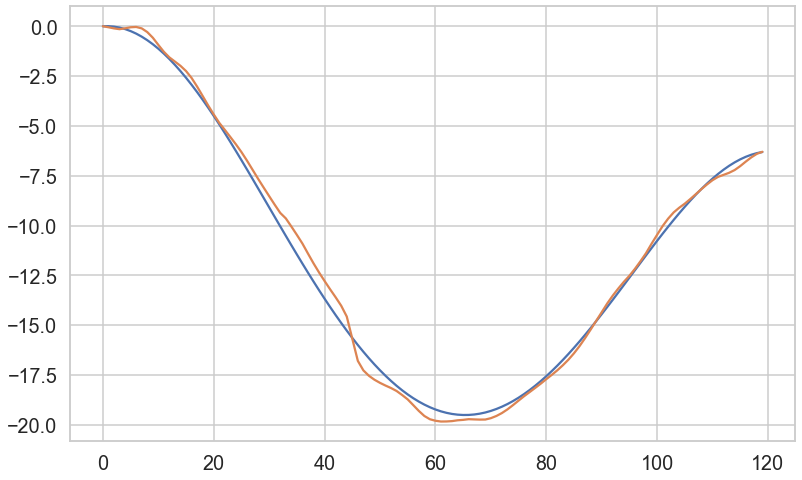

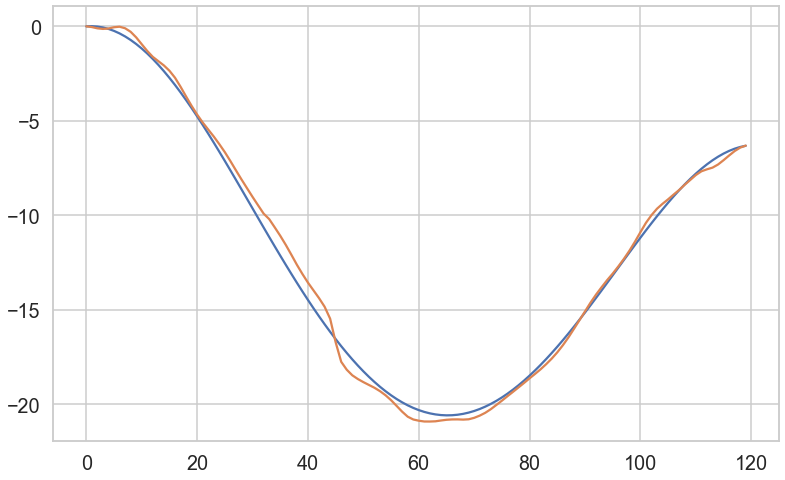

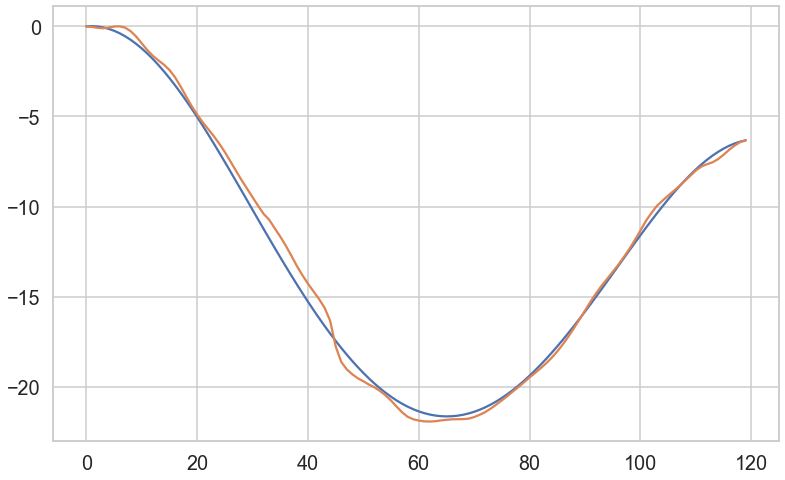

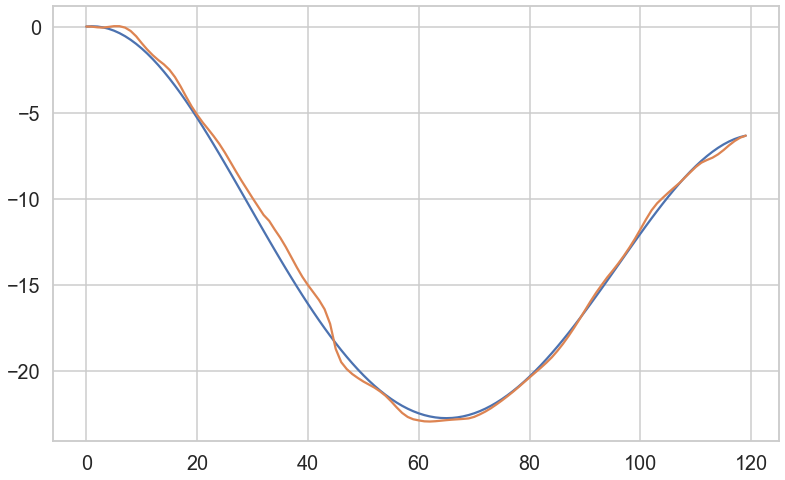

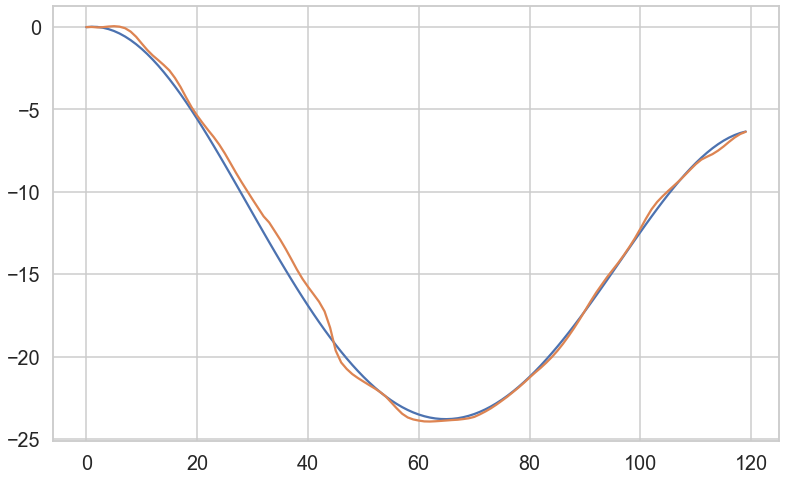

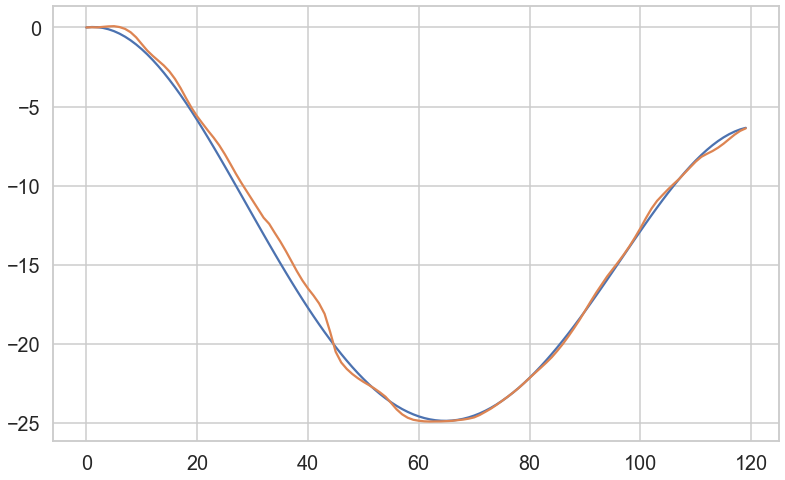

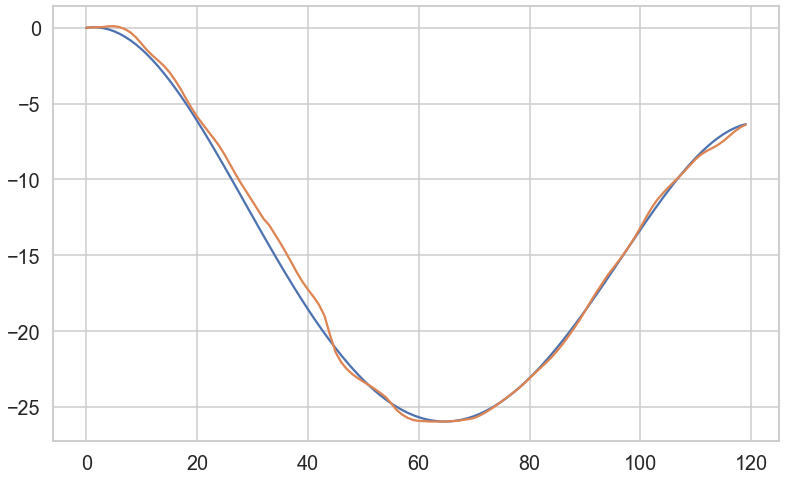

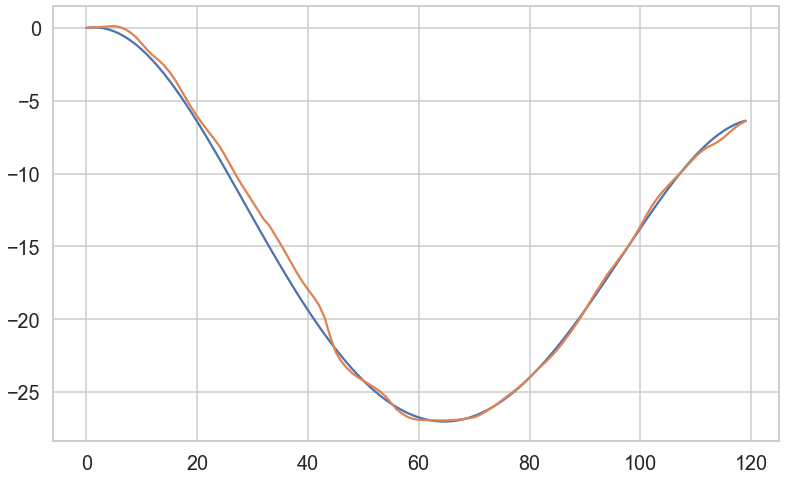

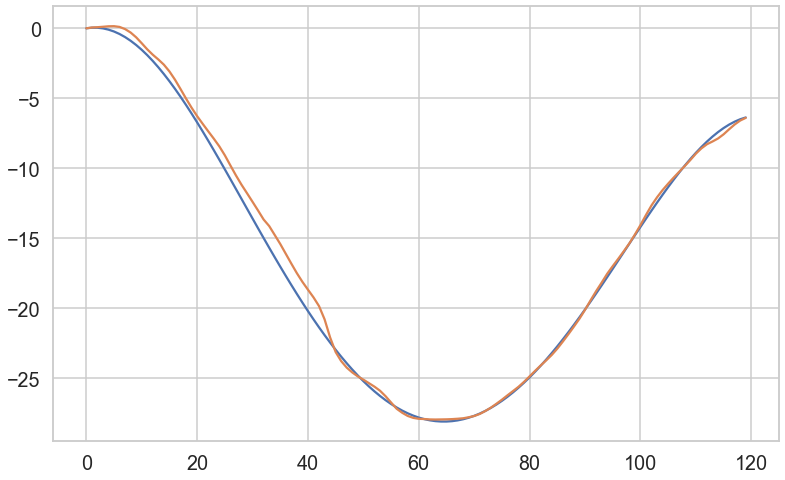

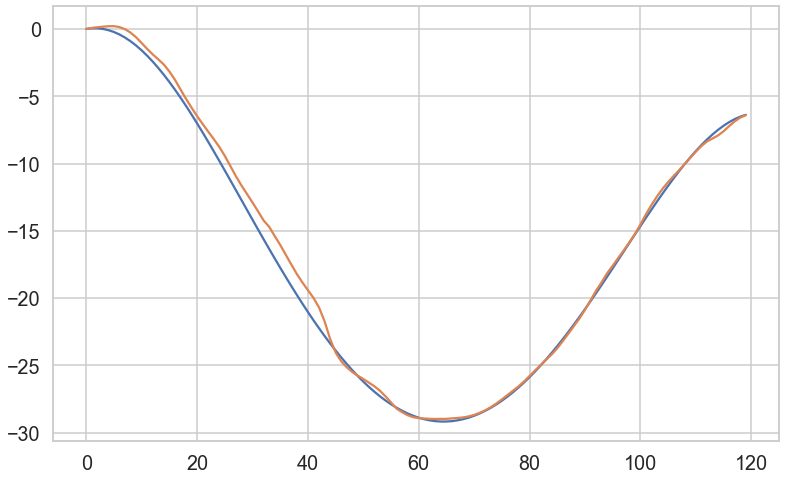

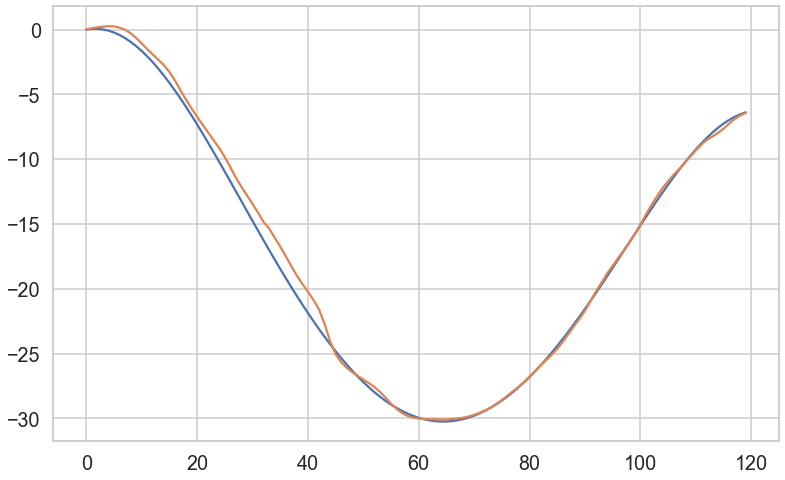

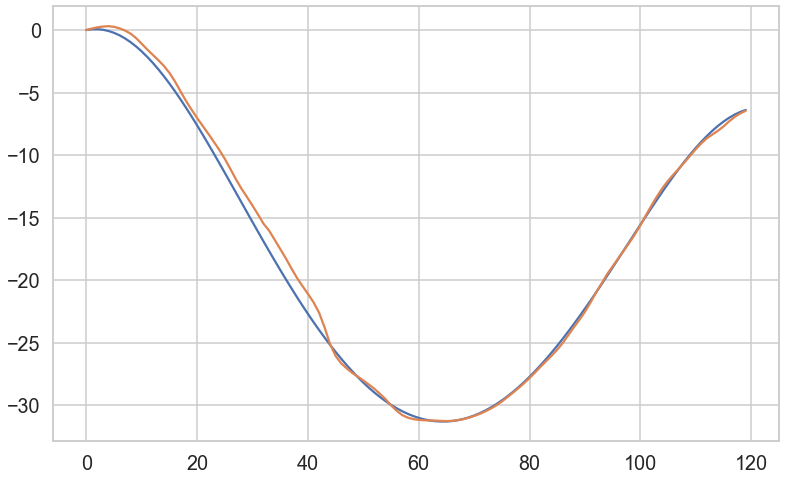

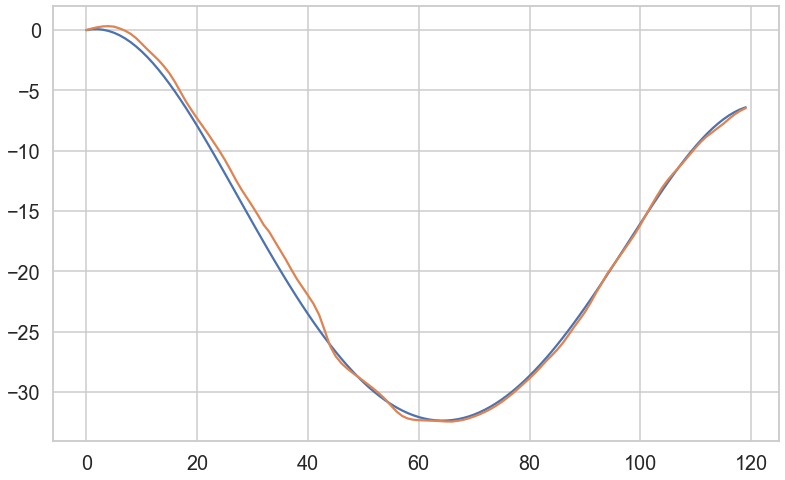

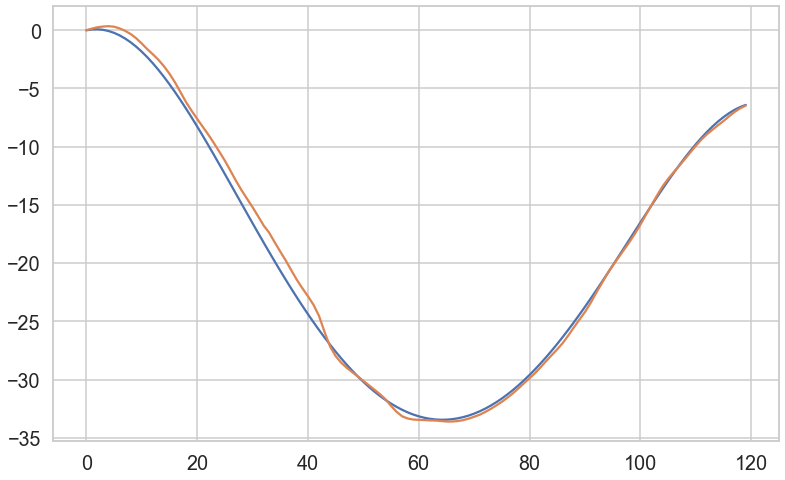

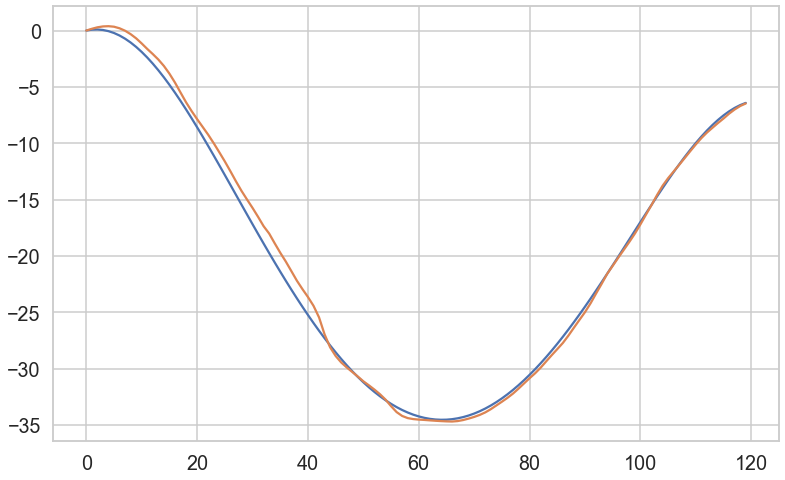

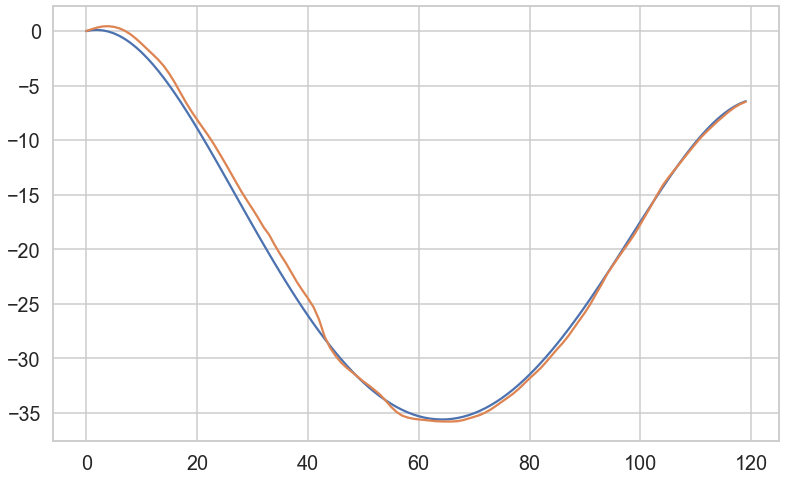

In [20]:

for k in range(penn_data.shape[0]):
    
    sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(1,1,1)
    
    for i in [0]:#range(i_data.shape[1]):
        initial_phase = np.angle(penn_data[k, 0, 400])
        i_curve = np.unwrap(np.angle(penn_data[k, :, 400]))-initial_phase
        #i_gradient = np.gradient(i_curve[mask])
        #neg_shift_inds = np.array(np.argwhere(i_gradient<-np.pi/2.3).squeeze())
        #if neg_shift_inds.shape == ():
        #    neg_shift_inds = np.array([neg_shift_inds])
            
        #phase_shift = phase_shift_processor(npi_phase_shift_dict[r])

        
        #phase_npi_correction = 1 * np.round((synca_phase_model(r, roll=16)[mask] - i_curve[mask]) / (2*np.pi), 0)
        #if np.mean(phase_npi_correction) < 0.2:
        #ax.plot(np.arange(0, 60, 1)[mask],i_curve[mask] + phase_shift[mask], '.')
        
        ax.plot(np.arange(0, 120, 1), -synca_phase_model(k, roll=3, n=120))
        #mean_curve_jugaad[mask] += (i_curve[mask] + phase_npi_correction) / i_data.shape[1]
        #plt.show()
        
    #ax.plot(np.arange(0, 60, 1)[mask], mean_curve_jugaad[mask])
    ax.plot(i_curve)  

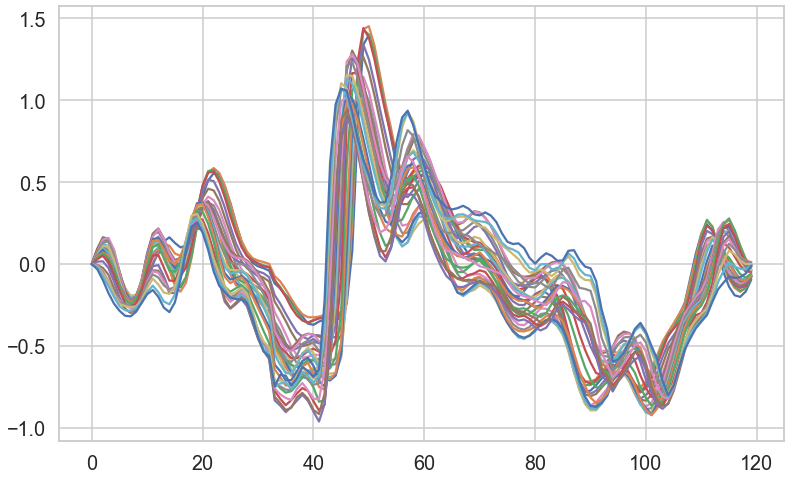

In [23]:
sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

for k in range(penn_data.shape[0]):
    
    for i in [0]:#range(i_data.shape[1]):
        initial_phase = np.angle(penn_data[k, 0, 400])
        i_curve = np.unwrap(np.angle(penn_data[k, :, 400]))-initial_phase
        #i_gradient = np.gradient(i_curve[mask])
        #neg_shift_inds = np.array(np.argwhere(i_gradient<-np.pi/2.3).squeeze())
        #if neg_shift_inds.shape == ():
        #    neg_shift_inds = np.array([neg_shift_inds])
            
        #phase_shift = phase_shift_processor(npi_phase_shift_dict[r])

        
        #phase_npi_correction = 1 * np.round((synca_phase_model(r, roll=16)[mask] - i_curve[mask]) / (2*np.pi), 0)
        #if np.mean(phase_npi_correction) < 0.2:
        #ax.plot(np.arange(0, 60, 1)[mask],i_curve[mask] + phase_shift[mask], '.')
        
        ax.plot(np.arange(0, 120, 1), -synca_phase_model(k, roll=4, n=120) - i_curve)
        #mean_curve_jugaad[mask] += (i_curve[mask] + phase_npi_correction) / i_data.shape[1]
        #plt.show()
        
    #ax.plot(np.arange(0, 60, 1)[mask], mean_curve_jugaad[mask])
    #ax.plot(i_curve)  

In [110]:
penn_h5file = h5py.File(cres2_vna_no_correction, 'r')
penn_data = penn_h5file['0'][:]
penn_data = penn_data[:, 0:120, :]
penn_data = np.roll(penn_data,33, axis=1)
print(penn_data.shape)

(31, 120, 801)


<ipython-input-112-ed68254efd46>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(13, 8))


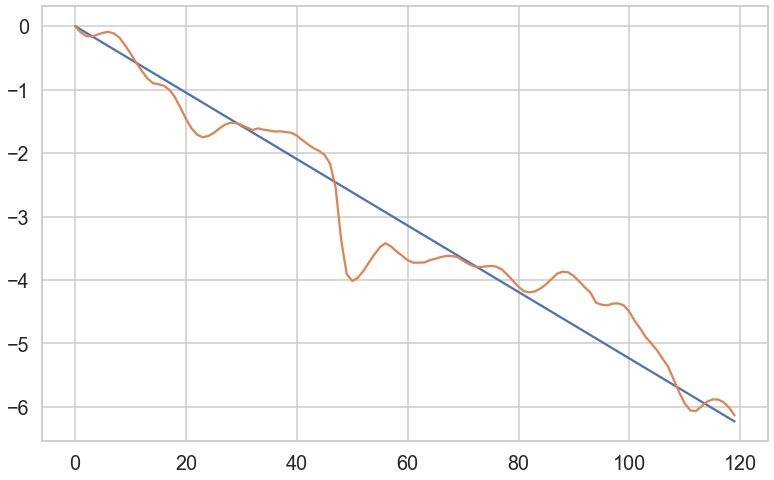

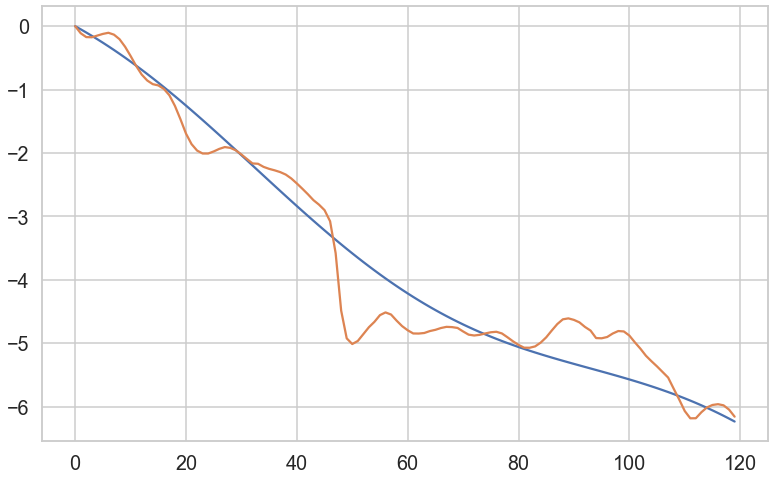

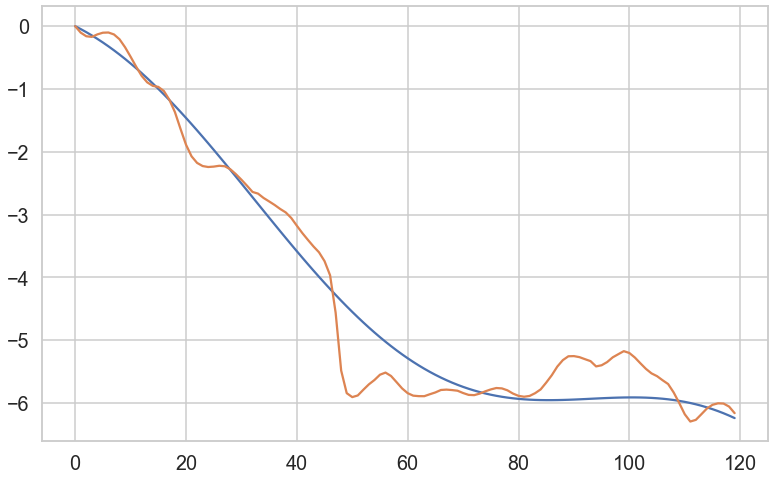

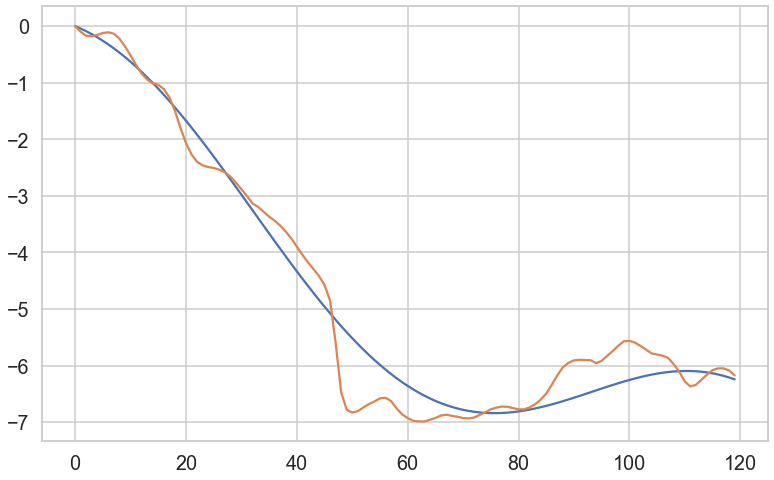

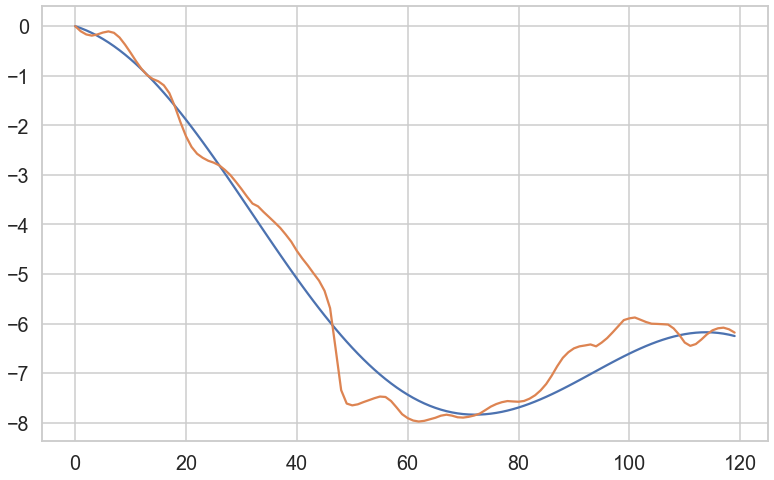

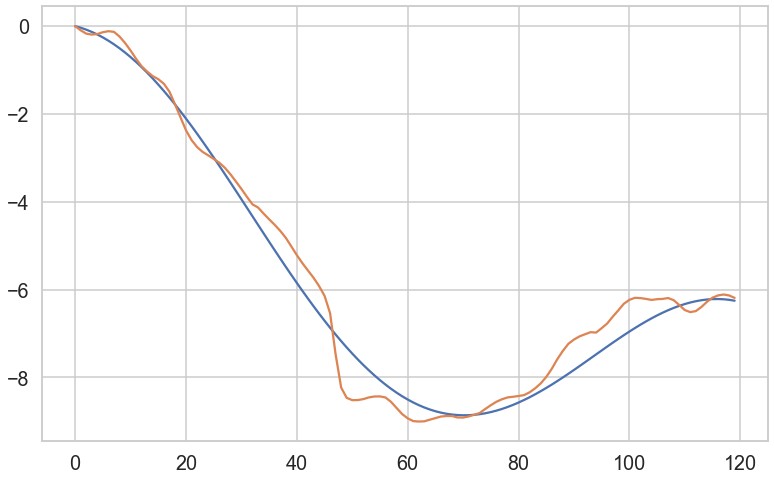

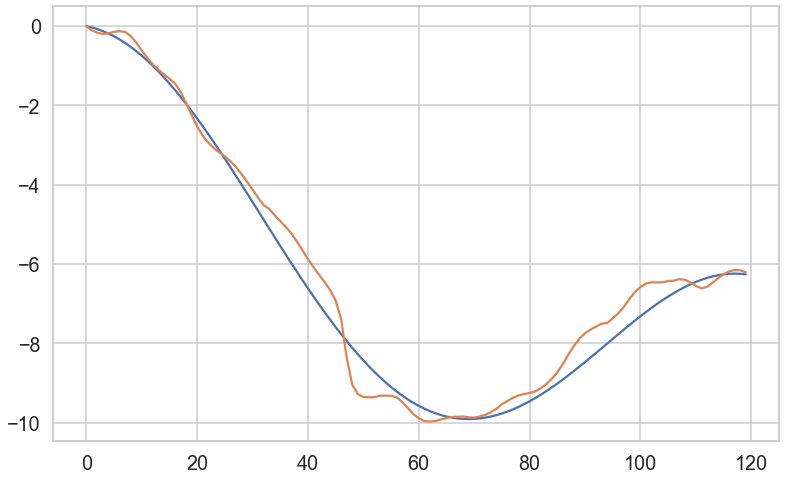

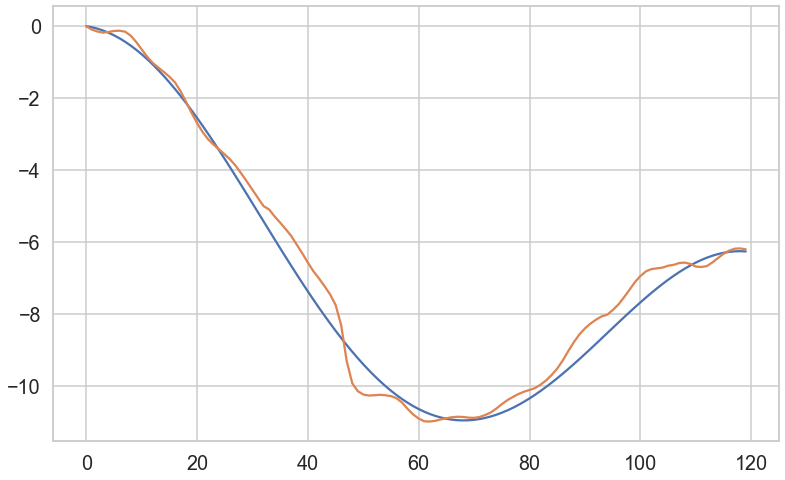

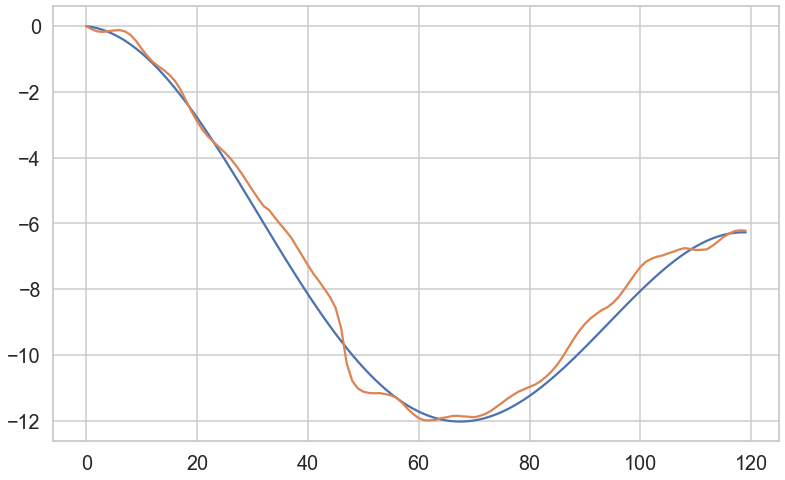

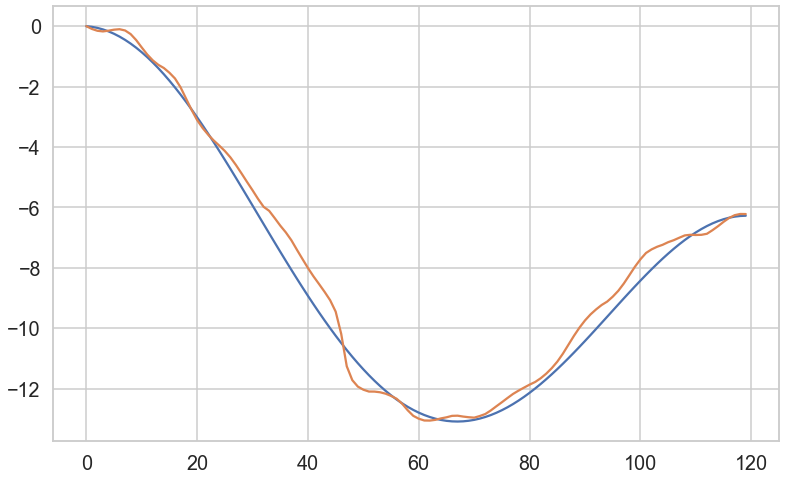

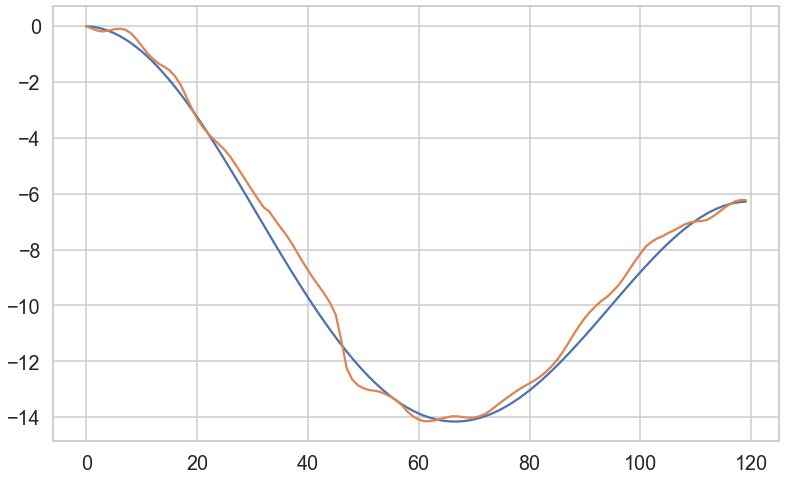

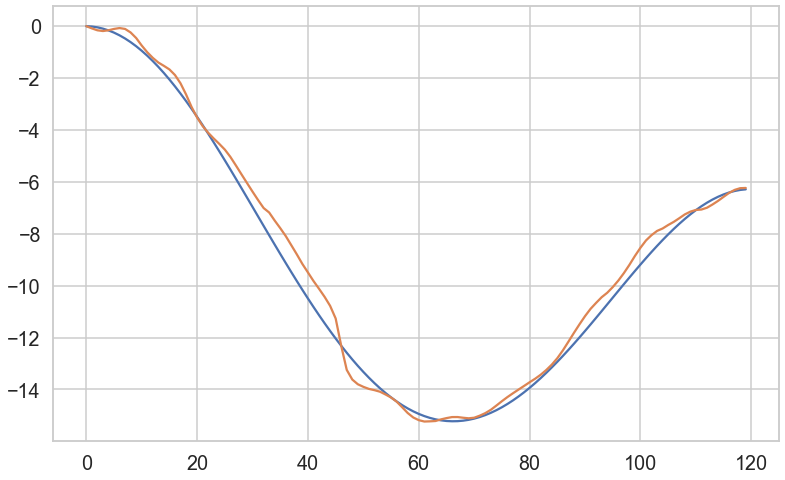

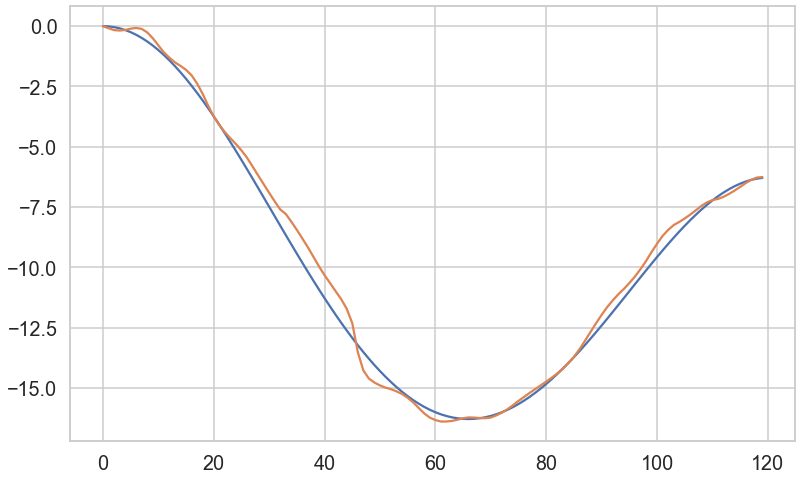

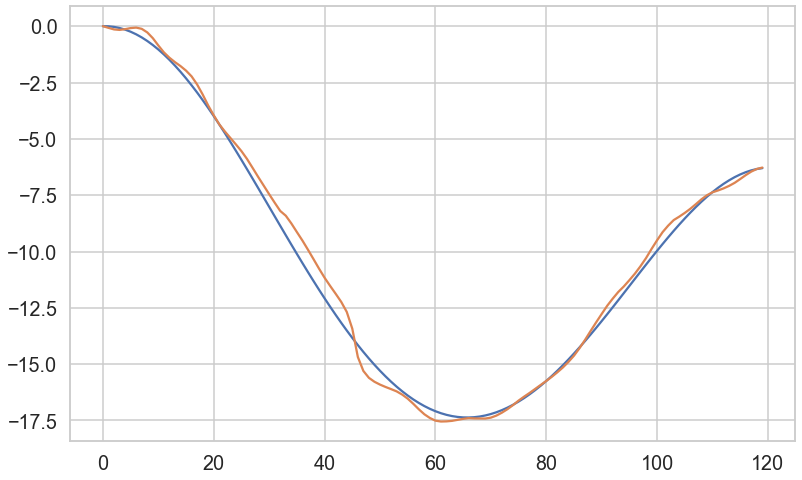

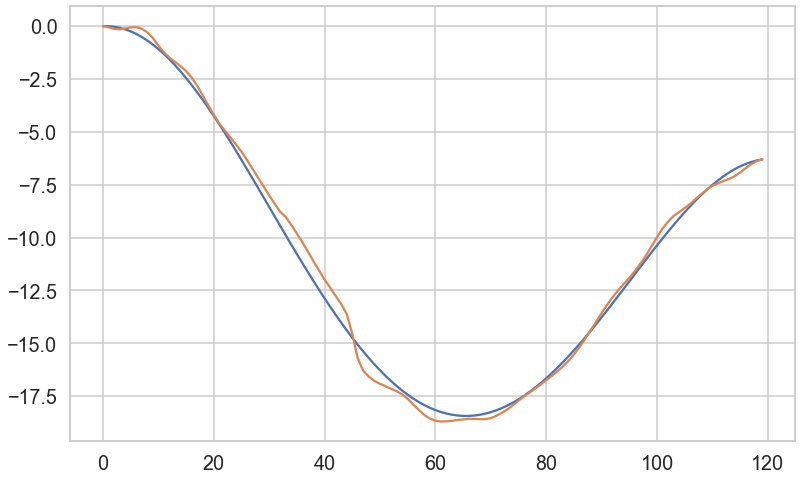

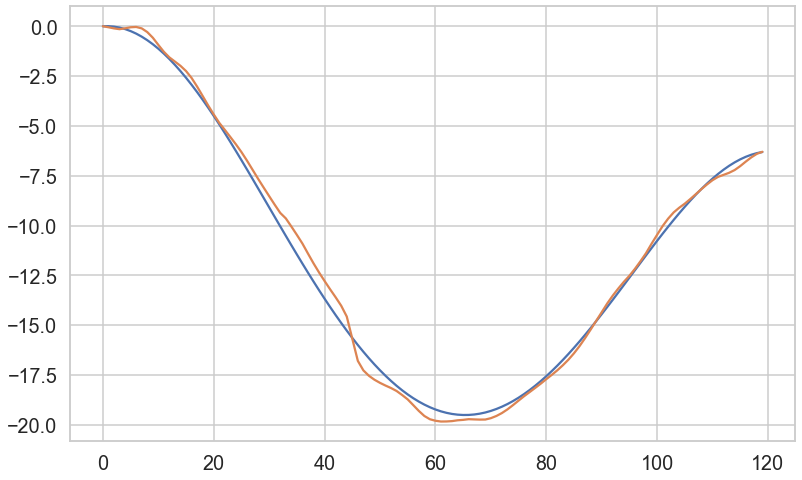

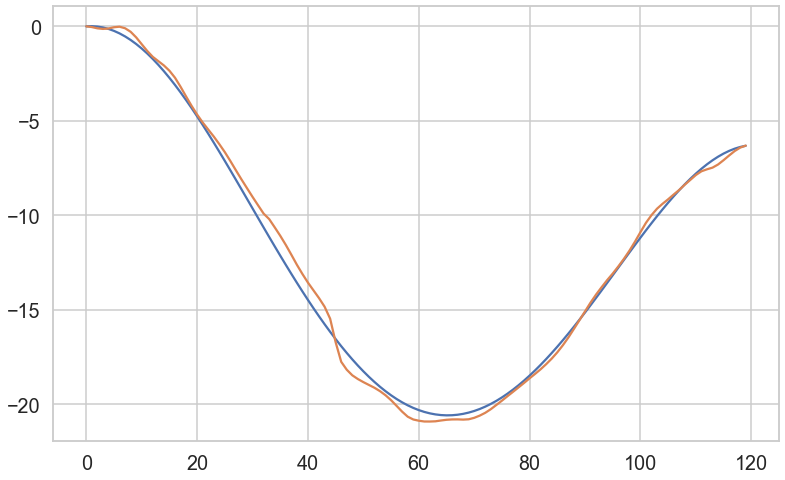

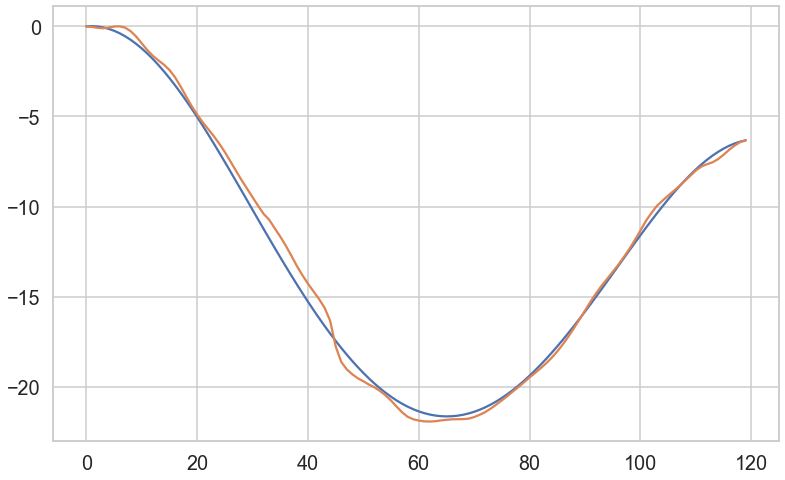

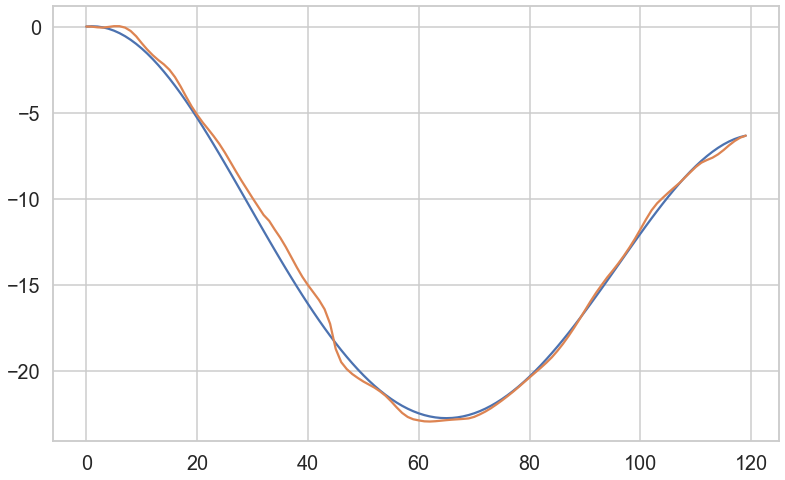

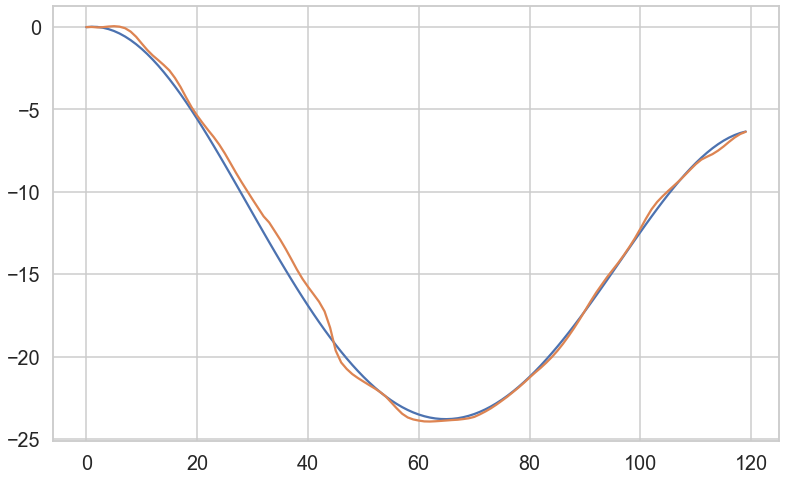

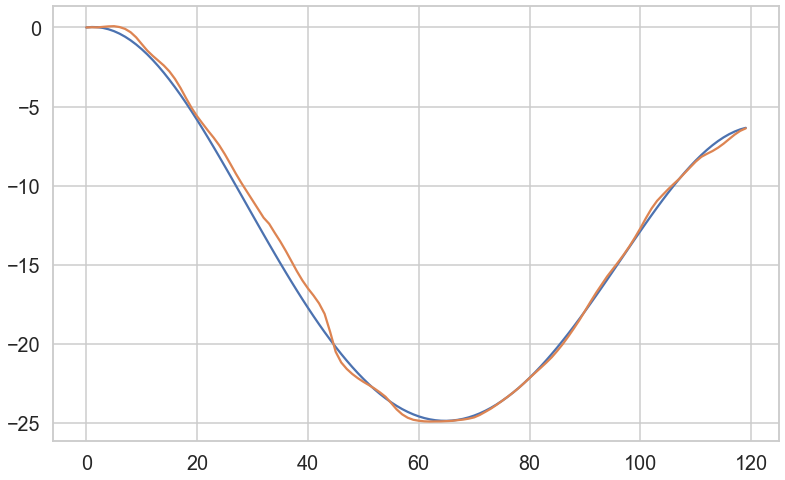

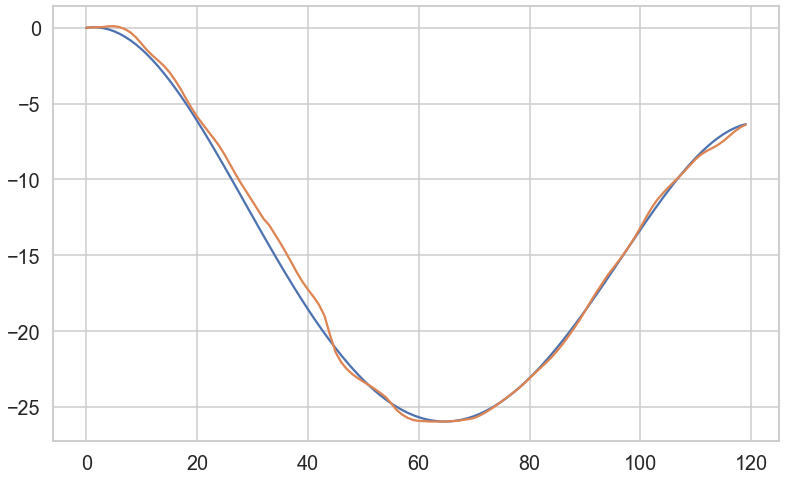

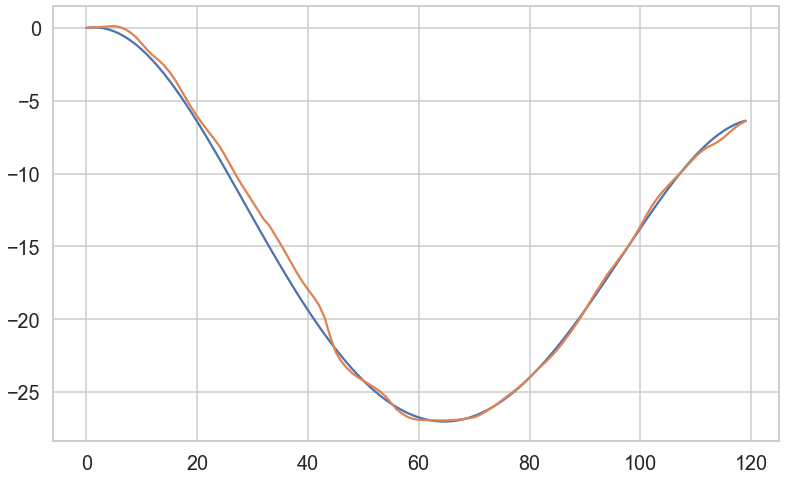

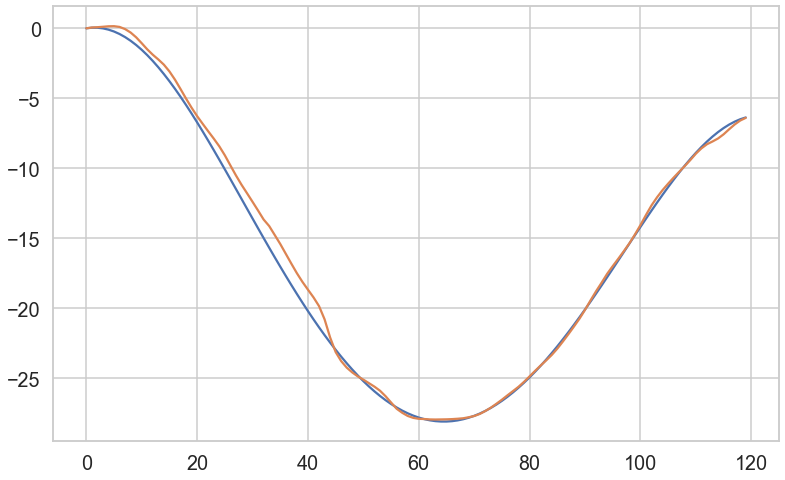

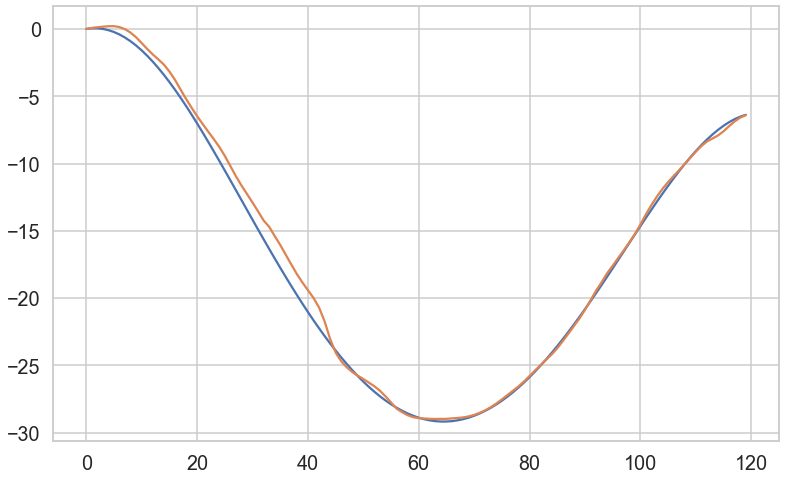

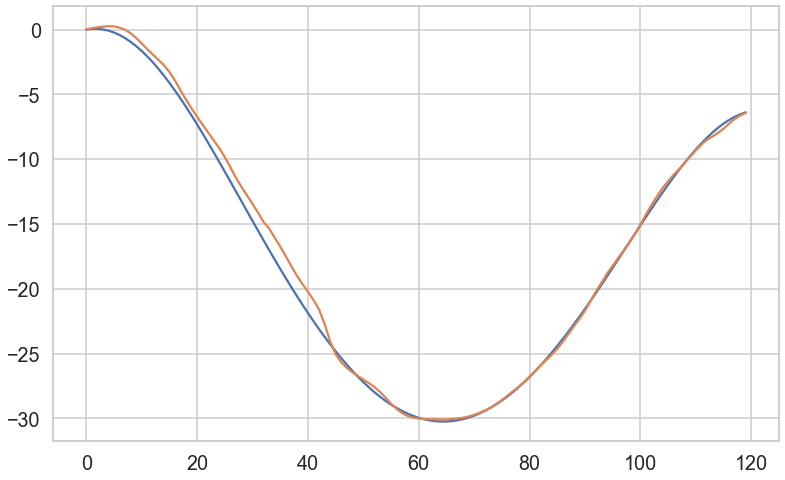

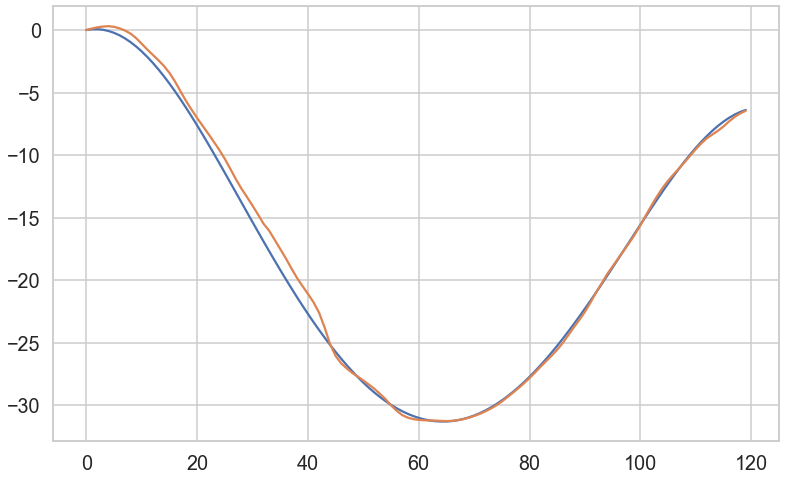

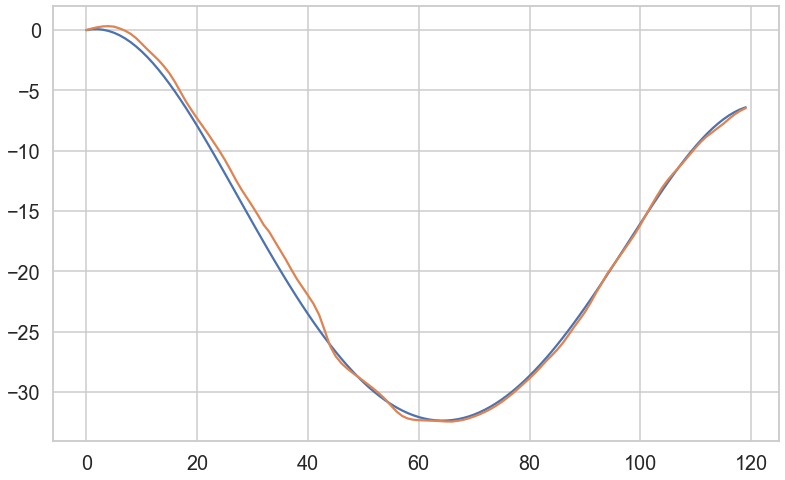

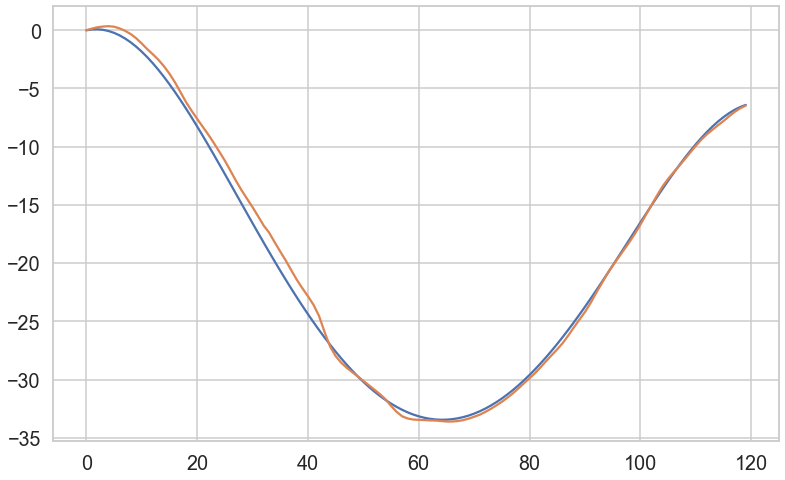

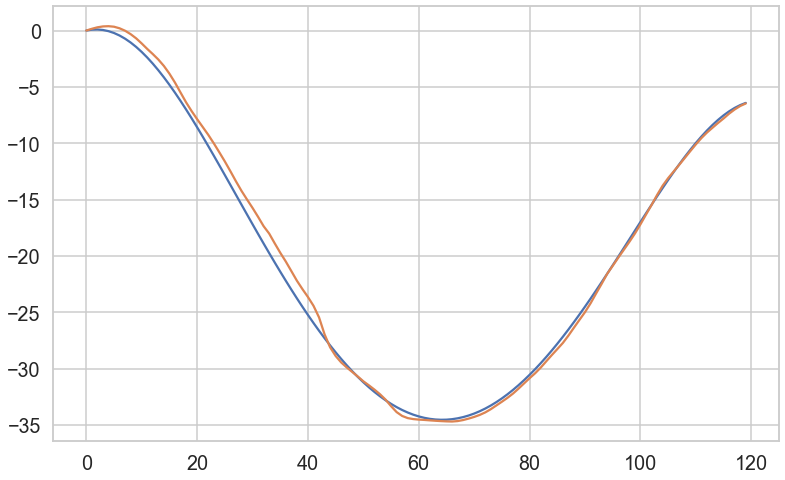

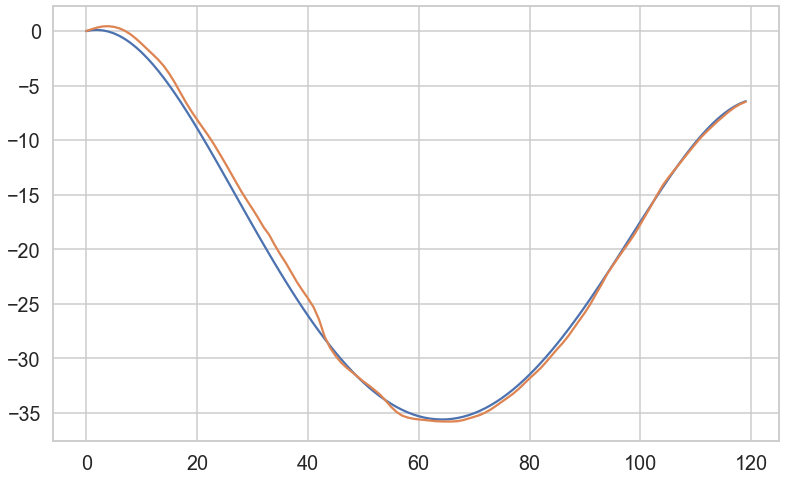

In [112]:

for k in range(penn_data.shape[0]):
    
    sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
    fig = plt.figure(figsize=(13, 8))
    ax = fig.add_subplot(1,1,1)

    
    for i in [0]:#range(i_data.shape[1]):
        initial_phase = np.angle(penn_data[k, 0, 400])
        i_curve = np.unwrap(np.angle(penn_data[k, :, 400]))-initial_phase
        #i_gradient = np.gradient(i_curve[mask])
        #neg_shift_inds = np.array(np.argwhere(i_gradient<-np.pi/2.3).squeeze())
        #if neg_shift_inds.shape == ():
        #    neg_shift_inds = np.array([neg_shift_inds])
            
        #phase_shift = phase_shift_processor(npi_phase_shift_dict[r])

        
        #phase_npi_correction = 1 * np.round((synca_phase_model(r, roll=16)[mask] - i_curve[mask]) / (2*np.pi), 0)
        #if np.mean(phase_npi_correction) < 0.2:
        #ax.plot(np.arange(0, 60, 1)[mask],i_curve[mask] + phase_shift[mask], '.')
        
        ax.plot(np.arange(0, 120, 1), -synca_phase_model(k, roll=3, n=120))
        #mean_curve_jugaad[mask] += (i_curve[mask] + phase_npi_correction) / i_data.shape[1]
        #plt.show()
        
    #ax.plot(np.arange(0, 60, 1)[mask], mean_curve_jugaad[mask])
    ax.plot(i_curve)  

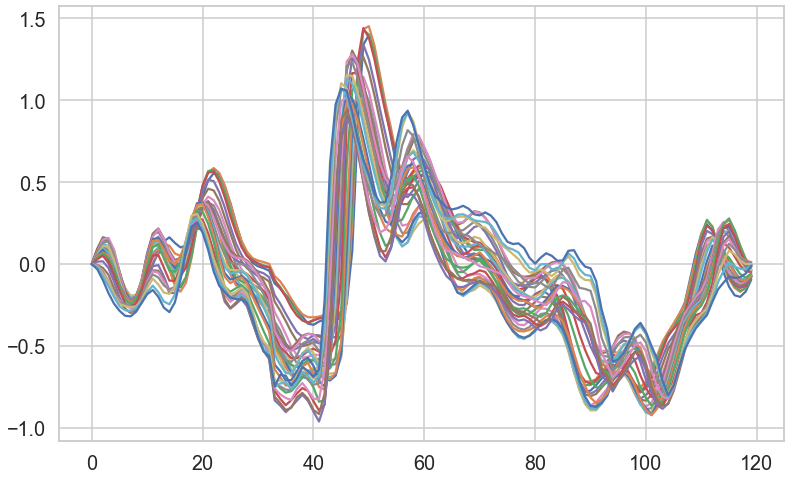

In [113]:
sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

for k in range(penn_data.shape[0]):
    
    for i in [0]:#range(i_data.shape[1]):
        initial_phase = np.angle(penn_data[k, 0, 400])
        i_curve = np.unwrap(np.angle(penn_data[k, :, 400]))-initial_phase
        #i_gradient = np.gradient(i_curve[mask])
        #neg_shift_inds = np.array(np.argwhere(i_gradient<-np.pi/2.3).squeeze())
        #if neg_shift_inds.shape == ():
        #    neg_shift_inds = np.array([neg_shift_inds])
            
        #phase_shift = phase_shift_processor(npi_phase_shift_dict[r])

        
        #phase_npi_correction = 1 * np.round((synca_phase_model(r, roll=16)[mask] - i_curve[mask]) / (2*np.pi), 0)
        #if np.mean(phase_npi_correction) < 0.2:
        #ax.plot(np.arange(0, 60, 1)[mask],i_curve[mask] + phase_shift[mask], '.')
        
        ax.plot(np.arange(0, 120, 1), -synca_phase_model(k, roll=4, n=120) - i_curve)
        #mean_curve_jugaad[mask] += (i_curve[mask] + phase_npi_correction) / i_data.shape[1]
        #plt.show()
        
    #ax.plot(np.arange(0, 60, 1)[mask], mean_curve_jugaad[mask])
    #ax.plot(i_curve)  

In [108]:
read_raw_penn_vna_data(cres2_vna_no_correction)


In [ ]:
sns.set_theme(style='whitegrid', context='talk', font_scale=1.2)
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(raw_penn_data['0']['0'])